GPU not available. Using CPU.


/Users/byeongyeongtae/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 209s 328ms/step - accuracy: 0.8600 - loss: 0.3176 - val_accuracy: 0.9843 - val_loss: 0.0630 - learning_rate: 1.0000e-04
Epoch 2/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 181s 287ms/step - accuracy: 0.9773 - loss: 0.0762 - val_accuracy: 0.9843 - val_loss: 0.0549 - learning_rate: 1.0000e-04
Epoch 3/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 173s 276ms/step - accuracy: 0.9814 - loss: 0.0599 - val_accuracy: 0.9879 - val_loss: 0.0404 - learning_rate: 1.0000e-04
Epoch 4/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 174s 276ms/step - accuracy: 0.9840 - loss: 0.0530 - val_accuracy: 0.9895 - val_loss: 0.0359 - learning_rate: 1.0000e-04
Epoch 5/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 163s 259ms/step - accuracy: 0.9865 - loss: 0.0430 - val_accuracy: 0.9900 - val_loss: 0.0338 - learning_rate: 1.0000e-04
Epoch 6/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 160s 254ms/step - accuracy: 0.9849 - loss: 0.0455 - val_accuracy: 0.9891 - val_loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 7/20
629/629 ━━━━━━━━━━━━━━━━━━━━ 

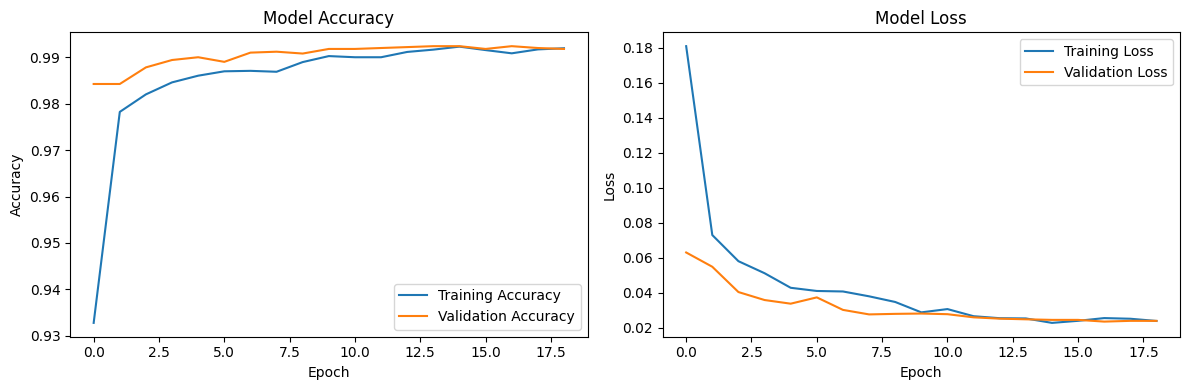

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class DogClassifier:
    def __init__(self, data_path, img_size=(224, 224), batch_size=32):
        """
        Initialize the dog classification model.
        
        :param data_path: Path to the dataset
        :param img_size: Input image size
        :param batch_size: Training batch size
        """
        self.data_path = data_path
        self.img_size = img_size + (3,)
        self.batch_size = batch_size
        self.class_names = ["not_dog", "dog"]
        self.num_classes = len(self.class_names)
        
        # GPU configuration
        self._configure_gpu()
        
    def _configure_gpu(self):
        """Configure GPU for optimal performance."""
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                print("GPU is available and configured.")
            except RuntimeError as e:
                print(f"GPU configuration error: {e}")
        else:
            print("GPU not available. Using CPU.")
    
    def load_data(self):
        """
        Load images from the dataset with robust error handling.
        
        :return: Tuple of images and labels
        """
        images, labels = [], []
        
        for class_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.data_path, class_name)
            
            if not os.path.exists(class_path):
                raise ValueError(f"Class directory not found: {class_path}")
            
            for img_file in os.listdir(class_path):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = tf.keras.utils.load_img(img_path, target_size=self.img_size[:2])
                    img_array = tf.keras.utils.img_to_array(img)
                    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
        
        return np.array(images), np.array(labels)
    
    def create_model(self):
        """
        Create a transfer learning model using MobileNetV2.
        
        :return: Compiled Keras model
        """
        base_model = MobileNetV2(
            weights='imagenet', 
            include_top=False, 
            input_shape=self.img_size
        )
        base_model.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, validation_split=0.2, epochs=20):
        """
        Train the model with advanced data augmentation and callbacks.
        
        :param validation_split: Fraction of data to use for validation
        :param epochs: Number of training epochs
        :return: Training history
        """
        # Load and split data
        images, labels = self.load_data()
        X_train, X_val, y_train, y_val = train_test_split(
            images, labels, 
            test_size=validation_split, 
            stratify=labels, 
            random_state=42
        )
        
        # Data augmentation
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        # Callbacks
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=3, 
            min_lr=1e-6
        )
        
        early_stop = EarlyStopping(
            monitor='val_accuracy', 
            patience=5, 
            restore_best_weights=True
        )
        
        # Create and train model
        model = self.create_model()
        
        history = model.fit(
            train_datagen.flow(X_train, y_train, batch_size=self.batch_size),
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=1
        )
        
        # Save model
        model.save('dog_classifier.keras')
        
        return history
    
    def plot_training_history(self, history):
        """
        Plot training and validation accuracy/loss.
        
        :param history: Model training history
        """
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def predict(self, image_path):
        """
        Predict whether an image contains a dog.
        
        :param image_path: Path to the image to predict
        :return: Prediction and confidence
        """
        try:
            # Load and preprocess image
            img = tf.keras.utils.load_img(image_path, target_size=self.img_size[:2])
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)
            
            # Load the saved model
            model = tf.keras.models.load_model('dog_classifier.keras')
            
            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]
            
            return self.class_names[predicted_class], confidence
        
        except Exception as e:
            print(f"Prediction error: {e}")
            return None, None

# Usage example
if __name__ == '__main__':
    # Initialize and train the classifier
    classifier = DogClassifier(data_path=r'C:\Users\jinao\OneDrive\바탕 화면\archive (2)\archive\Dog vs Not-Dog')
    history = classifier.train()
    
    # Plot training history
    classifier.plot_training_history(history)
    
    

In [3]:
# Make a prediction
result, confidence = classifier.predict(r'C:\Users\jinao\OneDrive\바탕 화면\archive (2)\archive\Test\test1.jpg')
if result:
    print(f"Prediction: {result}, Confidence: {confidence:.2f}")

Prediction error: [Errno 2] No such file or directory: 'C:\\Users\\jinao\\OneDrive\\바탕 화면\\archive (2)\\archive\\Test\\test1.jpg'


In [4]:
# Make a prediction
result, confidence = classifier.predict(r'C:\Users\jinao\OneDrive\바탕 화면\archive (2)\archive\Test\test2.jpg')
if result:
    print(f"Prediction: {result}, Confidence: {confidence:.2f}")

Prediction error: [Errno 2] No such file or directory: 'C:\\Users\\jinao\\OneDrive\\바탕 화면\\archive (2)\\archive\\Test\\test2.jpg'
